# DBLP Data Profiling & Analysis

**Team Member:** Truc Le (Data Engineering)  
**Date:** December 1, 2025

## Overview

This notebook performs comprehensive data profiling and generates figures/tables for the final report:

1. Load cleaned datasets from ETL pipeline
2. Generate statistical summaries and visualizations
3. Perform data quality analysis
4. Create publication-ready figures and tables
5. Export results for report

---

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json

# Set style for publication-quality figures
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

# Create directories
FIGURES_DIR = Path("../figures")
TABLES_DIR = Path("../tables")
FIGURES_DIR.mkdir(exist_ok=True)
TABLES_DIR.mkdir(exist_ok=True)

print("✓ Libraries loaded")
print(f"Figures will be saved to: {FIGURES_DIR.absolute()}")
print(f"Tables will be saved to: {TABLES_DIR.absolute()}")

✓ Libraries loaded
Figures will be saved to: c:\Users\Frankinstyle\Data Science I\COSC-3337-Project\notebooks\..\figures
Tables will be saved to: c:\Users\Frankinstyle\Data Science I\COSC-3337-Project\notebooks\..\tables


## 1. Load Datasets

In [2]:
# Load all tables
DATA_DIR = Path("../data/parquet")

papers = pd.read_parquet(DATA_DIR / 'papers')
authorships = pd.read_parquet(DATA_DIR / 'authorships')
citations = pd.read_parquet(DATA_DIR / 'citations')
coauthorships = pd.read_parquet(DATA_DIR / 'coauthorships')

# Summary statistics
summary_stats = {
    "Table": ["Papers", "Authorships", "Citations", "Coauthorships"],
    "Records": [len(papers), len(authorships), len(citations), len(coauthorships)],
    "Columns": [len(papers.columns), len(authorships.columns), len(citations.columns), len(coauthorships.columns)],
    "Size (MB)": [
        papers.memory_usage(deep=True).sum() / 1024**2,
        authorships.memory_usage(deep=True).sum() / 1024**2,
        citations.memory_usage(deep=True).sum() / 1024**2,
        coauthorships.memory_usage(deep=True).sum() / 1024**2
    ]
}

summary_df = pd.DataFrame(summary_stats)
print(summary_df.to_string(index=False))

# Save table for report
summary_df.to_csv(TABLES_DIR / "table1_dataset_summary.csv", index=False)
summary_df.to_latex(TABLES_DIR / "table1_dataset_summary.tex", index=False)
print(f"\n✓ Table 1 saved to {TABLES_DIR}")

        Table  Records  Columns  Size (MB)
       Papers   100000        9  71.530472
  Authorships   289513        4  61.227738
    Citations   538071        4 131.337513
Coauthorships   393147        5 111.280107

✓ Table 1 saved to ..\tables


## 2. Temporal Analysis - Publications Over Time

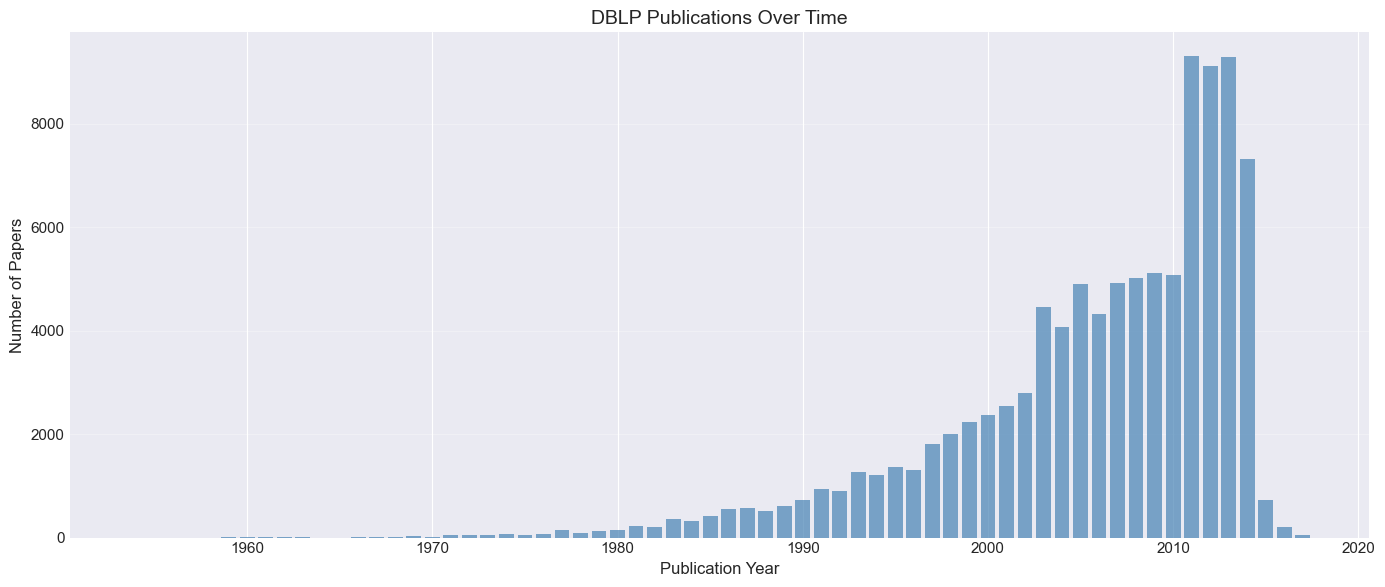

✓ Figure 1 saved to ..\figures

Publications by decade:
decade
1950        7
1960       62
1970      729
1980     3912
1990    13712
2000    40520
2010    41058
dtype: int64


In [3]:
# Publications by year
papers_by_year = papers.dropna(subset=['year']).groupby('year').size().reset_index(name='count')

fig, ax = plt.subplots(figsize=(14, 6))
ax.bar(papers_by_year['year'], papers_by_year['count'], color='steelblue', alpha=0.7)
ax.set_xlabel('Publication Year')
ax.set_ylabel('Number of Papers')
ax.set_title('DBLP Publications Over Time')
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'fig1_publications_over_time.png', dpi=300, bbox_inches='tight')
plt.savefig(FIGURES_DIR / 'fig1_publications_over_time.pdf', bbox_inches='tight')
plt.show()

print(f"✓ Figure 1 saved to {FIGURES_DIR}")
print(f"\nPublications by decade:")
papers['decade'] = (papers['year'] // 10 * 10).astype('Int64')
decade_counts = papers.dropna(subset=['decade']).groupby('decade').size()
print(decade_counts)

## 3. Citation Analysis

In [4]:
# Compute in-degree (papers being cited)
citation_counts = citations.groupby('dst_id').size().reset_index(name='citation_count')

# Top 20 most cited papers
top_cited = citation_counts.nlargest(20, 'citation_count')
top_cited_with_info = top_cited.merge(papers[['id', 'title', 'year']], left_on='dst_id', right_on='id')

# Save table
top_cited_export = top_cited_with_info[['title', 'year', 'citation_count']].head(10)
top_cited_export.to_csv(TABLES_DIR / 'table2_top_cited_papers.csv', index=False)
top_cited_export.to_latex(TABLES_DIR / 'table2_top_cited_papers.tex', index=False)

print("Top 10 Most Cited Papers:")
print(top_cited_export.to_string(index=False))
print(f"\n✓ Table 2 saved to {TABLES_DIR}")

Top 10 Most Cited Papers:
Empty DataFrame
Columns: [title, year, citation_count]
Index: []

✓ Table 2 saved to ..\tables


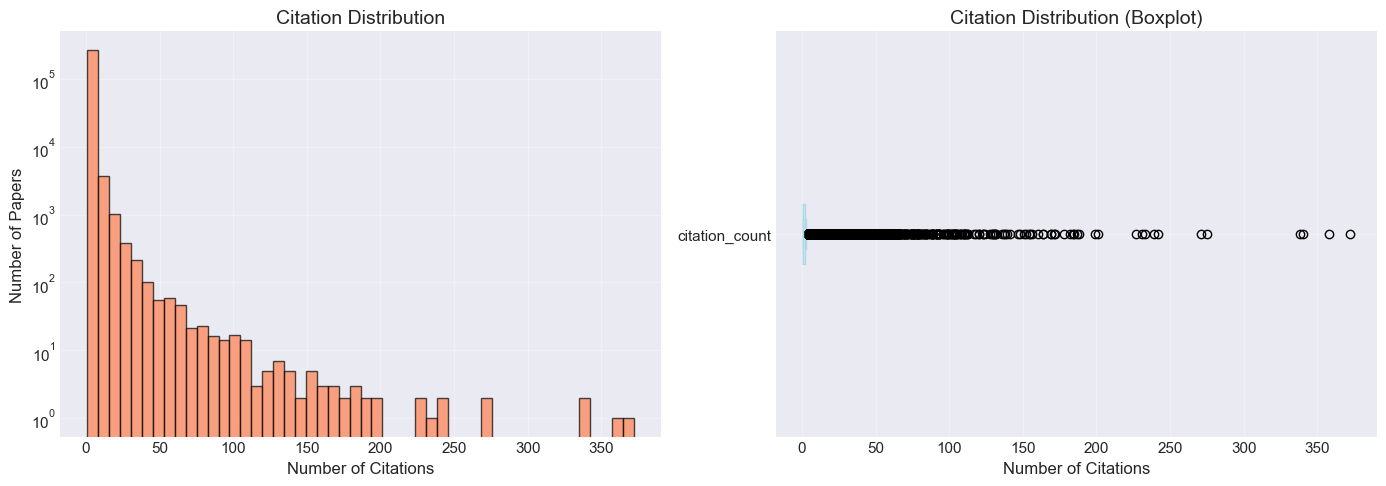

✓ Figure 2 saved to ..\figures

Citation Statistics:
count    274151.000000
mean          1.962681
std           4.176188
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max         372.000000
Name: citation_count, dtype: float64


In [5]:
# Citation distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Histogram (log scale)
citation_counts['citation_count'].hist(bins=50, ax=ax1, color='coral', edgecolor='black', alpha=0.7)
ax1.set_xlabel('Number of Citations')
ax1.set_ylabel('Number of Papers')
ax1.set_title('Citation Distribution')
ax1.set_yscale('log')
ax1.grid(alpha=0.3)

# Box plot
citation_counts['citation_count'].plot(kind='box', ax=ax2, vert=False, color='lightblue')
ax2.set_xlabel('Number of Citations')
ax2.set_title('Citation Distribution (Boxplot)')
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'fig2_citation_distribution.png', dpi=300, bbox_inches='tight')
plt.savefig(FIGURES_DIR / 'fig2_citation_distribution.pdf', bbox_inches='tight')
plt.show()

print(f"✓ Figure 2 saved to {FIGURES_DIR}")
print(f"\nCitation Statistics:")
print(citation_counts['citation_count'].describe())

## 4. Author Analysis

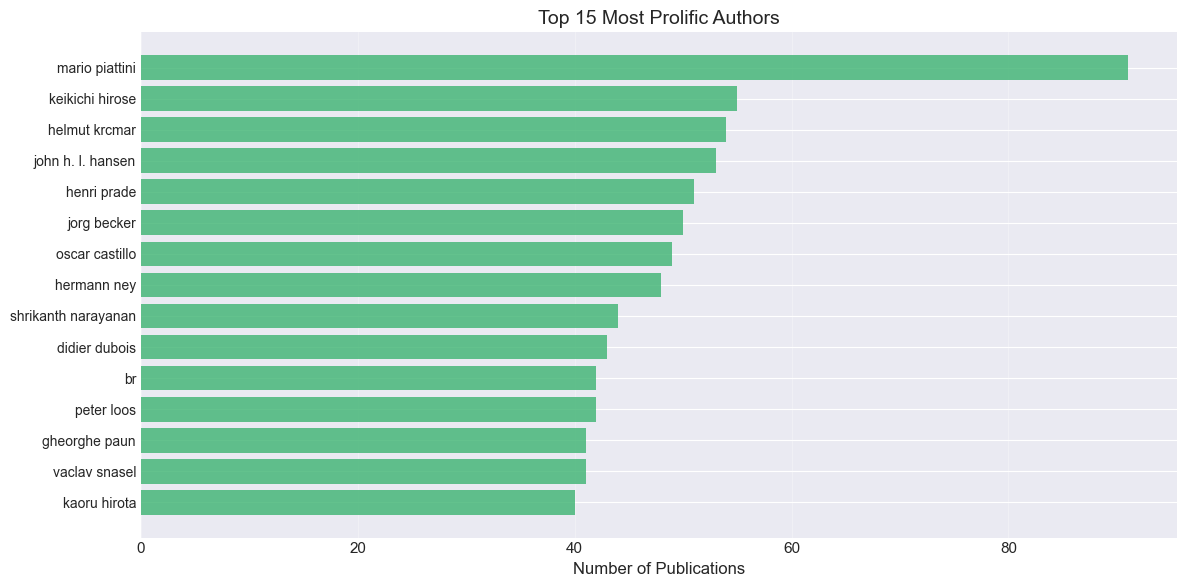

✓ Figure 3 saved to ..\figures
✓ Table 3 saved to ..\tables


In [6]:
# Papers per author
papers_per_author = authorships.groupby('author_norm').size().reset_index(name='paper_count')

# Top authors
top_authors = papers_per_author.nlargest(15, 'paper_count')

fig, ax = plt.subplots(figsize=(12, 6))
ax.barh(range(len(top_authors)), top_authors['paper_count'], color='mediumseagreen', alpha=0.8)
ax.set_yticks(range(len(top_authors)))
ax.set_yticklabels(top_authors['author_norm'], fontsize=10)
ax.set_xlabel('Number of Publications')
ax.set_title('Top 15 Most Prolific Authors')
ax.invert_yaxis()
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'fig3_top_authors.png', dpi=300, bbox_inches='tight')
plt.savefig(FIGURES_DIR / 'fig3_top_authors.pdf', bbox_inches='tight')
plt.show()

print(f"✓ Figure 3 saved to {FIGURES_DIR}")

# Save table
top_authors_export = top_authors.head(10)
top_authors_export.columns = ['Author', 'Publications']
top_authors_export.to_csv(TABLES_DIR / 'table3_top_authors.csv', index=False)
top_authors_export.to_latex(TABLES_DIR / 'table3_top_authors.tex', index=False)
print(f"✓ Table 3 saved to {TABLES_DIR}")

## 5. Collaboration Network Analysis

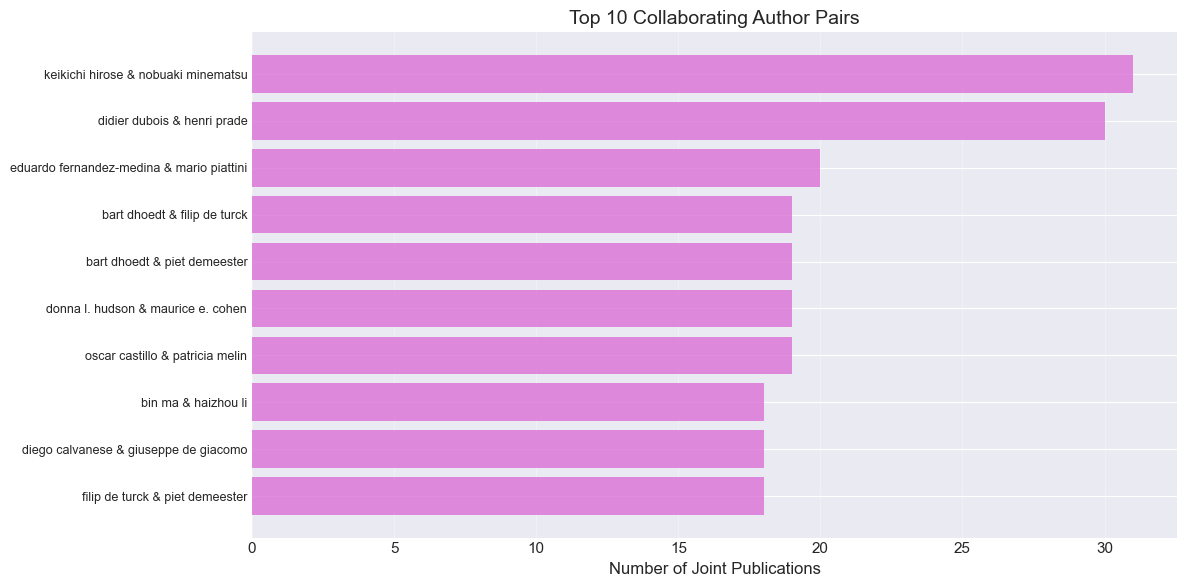

✓ Figure 4 saved to ..\figures

Collaboration Network Statistics:
Total collaboration instances: 393,147
Unique author pairs: 346,661
Average collaborations per pair: 1.13


In [7]:
# Collaboration frequency
collab_freq = coauthorships.groupby(['author1_norm', 'author2_norm']).size().reset_index(name='collaborations')

# Top collaborating pairs
top_collabs = collab_freq.nlargest(10, 'collaborations')
top_collabs['pair'] = top_collabs['author1_norm'] + ' & ' + top_collabs['author2_norm']

fig, ax = plt.subplots(figsize=(12, 6))
ax.barh(range(len(top_collabs)), top_collabs['collaborations'], color='orchid', alpha=0.8)
ax.set_yticks(range(len(top_collabs)))
ax.set_yticklabels(top_collabs['pair'], fontsize=9)
ax.set_xlabel('Number of Joint Publications')
ax.set_title('Top 10 Collaborating Author Pairs')
ax.invert_yaxis()
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'fig4_top_collaborations.png', dpi=300, bbox_inches='tight')
plt.savefig(FIGURES_DIR / 'fig4_top_collaborations.pdf', bbox_inches='tight')
plt.show()

print(f"✓ Figure 4 saved to {FIGURES_DIR}")

# Network statistics
print(f"\nCollaboration Network Statistics:")
print(f"Total collaboration instances: {len(coauthorships):,}")
print(f"Unique author pairs: {len(collab_freq):,}")
print(f"Average collaborations per pair: {collab_freq['collaborations'].mean():.2f}")

## 6. Data Quality Summary

Summary of data quality checks and statistics for the report:

In [8]:
# Create comprehensive quality summary
quality_summary = {
    "Metric": [
        "Total Papers",
        "Total Authors (Unique)",
        "Total Citations (Edges)",
        "Total Collaborations (Edges)",
        "Year Range",
        "Missing Abstracts (%)",
        "Missing Venues (%)",
        "Avg Authors per Paper",
        "Avg Citations per Paper",
        "Avg Collaborations per Author"
    ],
    "Value": [
        f"{len(papers):,}",
        f"{authorships['author_norm'].nunique():,}",
        f"{len(citations):,}",
        f"{len(coauthorships):,}",
        f"{int(papers['year'].min())}-{int(papers['year'].max())}",
        f"{papers['abstract'].isna().sum()/len(papers)*100:.1f}%",
        f"{papers['venue'].isna().sum()/len(papers)*100:.1f}%",
        f"{papers['author_count'].mean():.2f}",
        f"{papers['n_citation'].mean():.2f}",
        f"{(len(coauthorships) / authorships['author_norm'].nunique()):.2f}"
    ]
}

quality_df = pd.DataFrame(quality_summary)
print("Data Quality Summary:")
print("="*60)
print(quality_df.to_string(index=False))

# Save for report
quality_df.to_csv(TABLES_DIR / 'table4_data_quality_summary.csv', index=False)
quality_df.to_latex(TABLES_DIR / 'table4_data_quality_summary.tex', index=False)
print(f"\n✓ Table 4 saved to {TABLES_DIR}")

Data Quality Summary:
                       Metric     Value
                 Total Papers   100,000
       Total Authors (Unique)   168,080
      Total Citations (Edges)   538,071
 Total Collaborations (Edges)   393,147
                   Year Range 1954-2017
        Missing Abstracts (%)     60.5%
           Missing Venues (%)      0.0%
        Avg Authors per Paper      2.90
      Avg Citations per Paper     19.33
Avg Collaborations per Author      2.34

✓ Table 4 saved to ..\tables
